## LAB3 C: Two Stream - 2D CNN and Optical Flow

### Proceedure:

- Make `DataLoader` carefully because we are using both RGB values and Optical Flow.
- Loosely follow model building instructions, Im going to do:
    - Non-frozen EfficientNetB0 backbone.
    - Gunnar Farneback Optical Flow (already precomputed from preprocessing).
    - Late fusion approach
- Train and evaluate.

In [1]:
import warnings
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
import numpy as np
import random

warnings.filterwarnings('ignore')

if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

print(device)

cuda


In [2]:
class UCF50TwoStreamDataset(Dataset):
    def __init__(self, rgb_npz_path, flow_npz_path, num_frames=16, transform_rgb=None, transform_flow=None):
        """
        rgb_npz_path: path to train/test.npz with RGB frames (H x W x 3)
        flow_npz_path: path to train/test_flow.npz with flow frames (H x W x 2)
        num_frames: number of frames to sample per video
        transform_rgb/flow: optional torchvision-style transforms applied to each frame
        """
        self.rgb_data = np.load(rgb_npz_path, allow_pickle=True)
        self.flow_data = np.load(flow_npz_path, allow_pickle=True)

        assert len(self.rgb_data['X']) == len(self.flow_data['X']), "Mismatch in RGB vs Flow videos"

        self.X_rgb = self.rgb_data['X']
        self.X_flow = self.flow_data['X']
        self.y = self.rgb_data['y']
        self.num_frames = num_frames
        self.transform_rgb = transform_rgb
        self.transform_flow = transform_flow

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        rgb_video = self.X_rgb[idx]    # shape: T x H x W x 3
        flow_video = self.X_flow[idx]  # shape: T x H x W x 2
        label = self.y[idx]

        T = rgb_video.shape[0]
        num_frames = self.num_frames

        # uniformly sample indices
        if T >= num_frames:
            indices = np.linspace(0, T-1, num_frames, dtype=int)
            rgb_frames = rgb_video[indices]
            flow_frames = flow_video[indices]
        else:
            # pad left with zeros
            pad_rgb = np.zeros((num_frames-T, *rgb_video.shape[1:]), dtype=np.uint8)
            pad_flow = np.zeros((num_frames-T, *flow_video.shape[1:]), dtype=np.uint8)
            rgb_frames = np.concatenate([pad_rgb, rgb_video], axis=0)
            flow_frames = np.concatenate([pad_flow, flow_video], axis=0)

        # apply optional transforms
        if self.transform_rgb:
            rgb_frames = np.stack([self.transform_rgb(frame) for frame in rgb_frames], axis=0)
        if self.transform_flow:
            flow_frames = np.stack([self.transform_flow(frame) for frame in flow_frames], axis=0)

        # convert to tensors: (T, C, H, W)
        rgb_frames = torch.from_numpy(rgb_frames).permute(0, 3, 1, 2).float() / 255.0
        flow_frames = torch.from_numpy(flow_frames).permute(0, 3, 1, 2).float() / 255.0

        return rgb_frames, flow_frames, torch.tensor(label, dtype=torch.long)

In [3]:
NUM_FRAMES = 16
BATCH_SIZE = 8

transform_rgb = T.Compose([
    T.ToPILImage(),
    T.Resize((224, 224)),
    T.ToTensor(),
    T.Normalize(
        mean=[0.485, 0.456, 0.406],  # ImageNet mean
        std=[0.229, 0.224, 0.225]    # ImageNet std
    ),
])

transform_flow = T.Compose([
    T.ToTensor(),
])

train_dataset = UCF50TwoStreamDataset(
    rgb_npz_path="data/UCF50_npz/train.npz",
    flow_npz_path="data/UCF50_npz/train_flow.npz",
    num_frames=NUM_FRAMES,
    transform_rgb=transform_rgb,
    transform_flow=transform_flow
)

test_dataset = UCF50TwoStreamDataset(
    rgb_npz_path="data/UCF50_npz/test.npz",
    flow_npz_path="data/UCF50_npz/test_flow.npz",
    num_frames=NUM_FRAMES,
    transform_rgb=transform_rgb,
    transform_flow=transform_flow
)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

for rgb_batch, flow_batch, labels in train_loader:
    print("RGB batch shape:", rgb_batch.shape)      # [B, T, 3, H, W]
    print("Flow batch shape:", flow_batch.shape)    # [B, T, 2, H, W]
    print("Labels shape:", labels.shape)
    break

RGB batch shape: torch.Size([8, 16, 224, 3, 224])
Flow batch shape: torch.Size([8, 16, 112, 2, 112])
Labels shape: torch.Size([8])


Epoch 1/10 | Train loss: 2.4034, acc: 0.3855 | Test loss: 3.0014, acc: 0.2197
Epoch 2/10 | Train loss: 0.6075, acc: 0.8263 | Test loss: 0.2036, acc: 0.9318
Epoch 3/10 | Train loss: 0.2422, acc: 0.9275 | Test loss: 0.0788, acc: 0.9697
Epoch 4/10 | Train loss: 0.1478, acc: 0.9580 | Test loss: 0.0616, acc: 0.9773
Epoch 5/10 | Train loss: 0.1342, acc: 0.9618 | Test loss: 0.0563, acc: 0.9848
Epoch 6/10 | Train loss: 0.1118, acc: 0.9733 | Test loss: 0.0856, acc: 0.9848
Epoch 7/10 | Train loss: 0.0724, acc: 0.9771 | Test loss: 0.0837, acc: 0.9697
Epoch 8/10 | Train loss: 0.0567, acc: 0.9828 | Test loss: 0.0822, acc: 0.9697
Epoch 9/10 | Train loss: 0.0374, acc: 0.9905 | Test loss: 0.0491, acc: 0.9848
Epoch 10/10 | Train loss: 0.0531, acc: 0.9847 | Test loss: 0.0379, acc: 0.9773


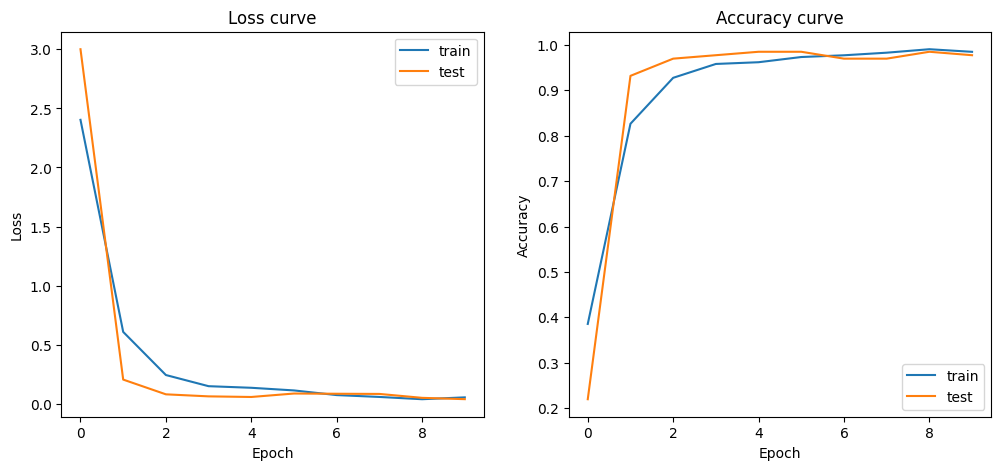

In [5]:
import torch.nn as nn
import torch.optim as optim
from torchvision.models import efficientnet_b0
import matplotlib.pyplot as plt

# =========================
# Hyperparameters
# =========================
NUM_CLASSES = 50  # UCF50
NUM_FRAMES = 16
LR = 1e-4
BATCH_SIZE = 8
EPOCHS = 10
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# =========================
# Flow CNN Backbone
# =========================
class FlowCNN(nn.Module):
    def __init__(self, out_dim=128):
        super().__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(2, 32, 3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),   # 112 -> 56
            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),   # 56 -> 28
            nn.Conv2d(64, 128, 3, padding=1),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d(1)  # 128 x 1 x 1
        )
        self.fc = nn.Linear(128, out_dim)

    def forward(self, x):
        # x: [B, 2, H, W]
        x = self.cnn(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

# =========================
# Two-stream late fusion
# =========================
class TwoStreamLateFusion(nn.Module):
    def __init__(self, num_classes=NUM_CLASSES, flow_emb_dim=128):
        super().__init__()
        # RGB EfficientNetB0
        self.rgb_model = efficientnet_b0(weights='IMAGENET1K_V1')
        self.rgb_model.classifier = nn.Identity()  # remove final fc
        self.rgb_emb_dim = 1280  # EfficientNetB0 last conv output

        # Flow CNN
        self.flow_model = FlowCNN(out_dim=flow_emb_dim)

        # Fusion FC
        self.fc = nn.Sequential(
            nn.Linear(self.rgb_emb_dim + flow_emb_dim, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, num_classes)
        )

    def forward(self, rgb, flow):
        # rgb: [B, T, 3, H, W], flow: [B, T, 2, H, W]
        B, T, _, _, _ = rgb.shape

        # Flatten time into batch
        rgb_flat = rgb.reshape(B*T, 3, 224, 224)
        flow_flat = flow.reshape(B*T, 2, 112, 112)

        # Forward through each backbone
        rgb_feat = self.rgb_model(rgb_flat)           # [B*T, 1280]
        flow_feat = self.flow_model(flow_flat)       # [B*T, flow_emb_dim]

        # Reshape back to [B, T, dim] and temporal average
        rgb_feat = rgb_feat.view(B, T, -1).mean(dim=1)
        flow_feat = flow_feat.view(B, T, -1).mean(dim=1)

        # Concatenate and classify
        fused = torch.cat([rgb_feat, flow_feat], dim=1)
        out = self.fc(fused)
        return out

# =========================
# Setup datasets & loaders
# =========================
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

# =========================
# Model, loss, optimizer
# =========================
model = TwoStreamLateFusion(num_classes=NUM_CLASSES).to(DEVICE)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LR)

# =========================
# Training loop
# =========================
train_losses, test_losses = [], []
train_accs, test_accs = [], []

for epoch in range(EPOCHS):
    model.train()
    running_loss, running_corrects, total = 0, 0, 0

    for rgb, flow, labels in train_loader:
        rgb = rgb.to(DEVICE)
        flow = flow.to(DEVICE)
        labels = labels.to(DEVICE)

        optimizer.zero_grad()
        outputs = model(rgb, flow)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * rgb.size(0)
        running_corrects += (outputs.argmax(1) == labels).sum().item()
        total += rgb.size(0)

    train_losses.append(running_loss/total)
    train_accs.append(running_corrects/total)

    # Validation
    model.eval()
    val_loss, val_corrects, val_total = 0, 0, 0
    with torch.no_grad():
        for rgb, flow, labels in test_loader:
            rgb = rgb.to(DEVICE)
            flow = flow.to(DEVICE)
            labels = labels.to(DEVICE)
            outputs = model(rgb, flow)
            loss = criterion(outputs, labels)

            val_loss += loss.item() * rgb.size(0)
            val_corrects += (outputs.argmax(1) == labels).sum().item()
            val_total += rgb.size(0)

    test_losses.append(val_loss/val_total)
    test_accs.append(val_corrects/val_total)

    print(f"Epoch {epoch+1}/{EPOCHS} | "
          f"Train loss: {train_losses[-1]:.4f}, acc: {train_accs[-1]:.4f} | "
          f"Test loss: {test_losses[-1]:.4f}, acc: {test_accs[-1]:.4f}")

# =========================
# Plot curves
# =========================
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(train_losses, label="train")
plt.plot(test_losses, label="test")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss curve")
plt.legend()

plt.subplot(1,2,2)
plt.plot(train_accs, label="train")
plt.plot(test_accs, label="test")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy curve")
plt.legend()

plt.show()